# 10種類の小さい画像（CIFAR-10）

*CIFAR-10*というデータセットは多数の小さい画像から構成されている。各画像に対して、その画像に映っているものを表わすテキストラベルが付与されている。

__目次__

- <a href="#overview">データセットの概要</a>

- <a href="#data_check">（画像、ラベル）の対を調べる</a>

- <a href="#make_h5">作業用のデータを整える</a>

___

<a id="overview"></a>
## データセットの概要

CIFAR-10は、機械学習の研究開発で著名なAlex Krizhevsky氏のトロント大学でのホームページから入手できる。

```
http://www.cs.toronto.edu/~kriz/cifar.html
```

このデータセットの源泉となるのは、8000万枚もの小さい画像からなる*Tiny Images*という著名なデータセットである[<a href="http://horatio.cs.nyu.edu/mit/tiny/data/index.html">link</a>]。CIFAR-10はそのごく一部を抜粋したもので、10種類のラベル（*airplane*, *automobile*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, *truck*）に絞られている。ちなみに、__CIFAR__の略称は(C)anadian (I)nstitute (for (A)dvanced (R)esearchからきている。

<img src="img/cifar-10.png" alt="CIFAR-10 examples" />

基本情報は以下の通りである。

- 6万枚の画像
- 大きさは32x32のRGB画像
- ラベルには10種類ある
- 各クラスの数は均等で、一クラスにつき6,000枚ある

まずはこの<a href="DataSources.ipynb">データセット自体を入手した</a>上で、その中身を覗いてみよう。

```
$ ls cifar-10-batches-bin
batches.meta.txt  data_batch_2.bin  data_batch_4.bin  readme.html
data_batch_1.bin  data_batch_3.bin  data_batch_5.bin  test_batch.bin
```

`batches.meta.txt`は単なるラベル名を示すテキストで、一行に一つのラベル。あとはバイナリ形式のバッチが6つある。訓練用のもの（`data_batch_*.bin`）と検証用のもの（`test_batch.bin`）からなる。ラベルの分布について、前掲のホームページより引用すると、

> The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

ということであるので、バッチを単独に使うと完全に均一ではないが、バッチを足し合わせるとどのクラスもまったく同じ枚数である。

<a id="data_check"></a>
## （画像、ラベル）の対を調べる

訓練データのファイルを開く。

In [2]:

import numpy as np
import matplotlib.pyplot as plt

toread = "data/cifar10/cifar-10-batches-bin/data_batch_1.bin"

f_bin = open(toread, mode="rb")

print(f_bin)


<_io.BufferedReader name='data/cifar10/cifar-10-batches-bin/data_batch_1.bin'>


重要なのは、正しくデータを読めているかどうか検証することである。一番わかやすいのは、自分の目で、「あるはずだ」という中身があることを確かめることである。ドキュメンテーションに目を通すと、今回のバイナリ形式はきわめて単純で、詳細は下記のとおりである。

- データ点の基本形は`<1 x label><3072 x pixel>`である。1バイトがラベルで、そのあとの3072ものバイトは画素値である。したがって、連続する3073バイトが一つの（画像、ラベル）の対に相当するので、各バッチでこれが1万回繰り返される。

- ラベルの取る値は0から9までである。
- 画像は32x32ピクセルで、一つの画素値に1バイトが使われる。色チャンネルが3つあって、red、 green、blueという順で続く。
- 画素値の並び方は*row-major*なので、二次元の画像として表示する場合は、配列の行ごとに埋めていく（それに対して、*column-major*の場合は列ごとに埋める）。

この程度の情報があれば難なく準備ができる。

In [3]:
print("First byte:") # should be a label.
b = f_bin.read(1)
print("bytes: ", b)
print("int: ", int.from_bytes(b, byteorder="big", signed=False))

First byte:
bytes:  b'\x06'
int:  6


ここで出てきたPythonのバイトデータ`b'\x06'`は、最初の1バイトを16進法(hexadecimal)で表記したものである。先頭の``\x``はバイトごとの区切りを示す。画素値は0から255の値を取るのだが、16進法の2桁を使うと、$0, 1, 2, \ldots$から$(15 \times 16^{1} + 15 \times 16^{0}) = 255$までの整数を表現することができるので、ちょうど良い。

続いて、次の5個のピクセルの値を見てみよう。

In [4]:
for i in range(5):
    b = f_bin.read(1)
    print("bytes: ", b)
    print("int: ", int.from_bytes(b, byteorder="big", signed=False))

bytes:  b';'
int:  59
bytes:  b'+'
int:  43
bytes:  b'2'
int:  50
bytes:  b'D'
int:  68
bytes:  b'b'
int:  98


いきなり新しい記号がここで出てきたが、たとえば`b';'`などは当然、普通の16進法の表記ではない。PythonはASCII記号を使って表わすことがたくさんある。今回は16進法の`0x3b`を`b';'`で表しているが、大事なのはその中身が正しいかどうかである。`seek()`で最初の画素値に戻り、画像の全ピクセルを読み込んでみる。

In [5]:
f_bin.seek(1)
my_array = np.zeros((32,32,3), dtype=np.uint8)
for c in range(3): # colour channel
    for i in range(32): # rows
        for j in range(32): # columns
            b = f_bin.read(1)
            my_array[i,j,c] = int.from_bytes(b, byteorder="big", signed=False)

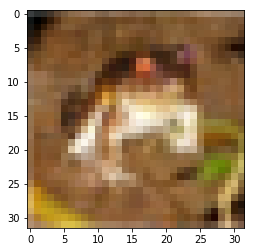

In [6]:
plt.imshow(my_array)

粗いことは粗いが、蛙の画像に見えることは確かである。この画像のラベルは6だったので、ゼロから数え上げて7番目のラベルとなる。付属データとしての`batches.meta.txt`の内容を覗いてみると、

```
$ cat batches.meta.txt
airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck
```

と嬉しいことに、6がfrogに相当する。もう一つのペアを見てみよう。

In [7]:
b = f_bin.read(1)
print("bytes: ", b)
print("int: ", int.from_bytes(b, byteorder="big", signed=False))
my_array = np.zeros((32,32,3), dtype=np.uint8)
for c in range(3): # colour channel
    for i in range(32): # rows
        for j in range(32): # columns
            b = f_bin.read(1)
            my_array[i,j,c] = int.from_bytes(b, byteorder="big", signed=False)

bytes:  b'\t'
int:  9


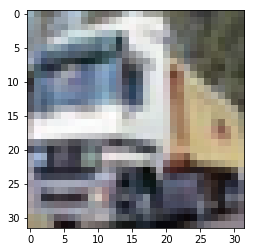

In [8]:
plt.imshow(my_array)

これも粗いが、そこそこ大きなトラックに見える。ラベルは9で、10番目のラベルである。これもめでたく、truckと確認できて、どうも正しく読めているようである。

<a id="make_h5"></a>
## 作業用のデータを整える

前節では、位置（縦、横）と色チャンネルの三次元配列を使ってカラー画像を表示していたのだが、学習に際しては、画像を一つの長いベクトルとしたほうが使い勝手が良い。次はこれらのベクトルを行とする二次元配列を構成して、階層型データファイルにまとめる作業であるが、そのために__PyTables__という大変便利なパッケージを使う[<a href="http://www.pytables.org/">link</a>]。

まずは新しい階層型ファイルを作る（.h5形式）。

In [9]:
import tables
import numpy as np
import matplotlib.pyplot as plt
import os

In [10]:
# Key information.
NUM_CLASSES = 10
NUM_LABELS = 1
NUM_PIXELS = 32*32
NUM_CHANNELS = 3
NUM_BATCHIM = 10000 # number of images per batch.

# A dictionary mapping label values (ints) to strings.
toread = "data/cifar10/cifar-10-batches-bin/batches.meta.txt"
LABEL_DICT = {}
with open(toread, mode="r", encoding="ascii") as f:
    for cnt, line in enumerate(f):
        LABEL_DICT[cnt] = line.split("\n")[0] # to remove the line-breaks.
    LABEL_DICT.pop(10) # to remove the empty line.

In [11]:
# Open file connection, writing new file to disk.
myh5 = tables.open_file("data/cifar10/data.h5",
                        mode="w",
                        title="CIFAR-10 data")
print(myh5) # currently empty.

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Fri Jul 27 10:35:59 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'



元の`RootGroup`には、訓練用と検証用のグループを追加する。

In [12]:
myh5.create_group(myh5.root, "train", "Training data")
myh5.create_group(myh5.root, "test", "Testing data")
print(myh5)

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Fri Jul 27 10:35:59 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'
/test (Group) 'Testing data'
/train (Group) 'Training data'



この`train`と`test`はそれぞれ、*enumerative array* (`EArray`クラス, 数え上げ配列)を持たせて、データを格納するための準備を始める。通常の`Array`オブジェクトと違って、あとでデータを追加することで伸ばし広げられる性質を有する。

In [13]:
# Training data arrays.
a = tables.UInt8Atom()
myh5.create_earray(myh5.root.train,
                   name="labels",
                   atom=a,
                   shape=(0,NUM_LABELS),
                   title="Label values")
a = tables.Float32Atom()
myh5.create_earray(myh5.root.train,
                   name="inputs",
                   atom=a,
                   shape=(0,NUM_CHANNELS*NUM_PIXELS),
                   title="Input images")

# Testing data arrays.
a = tables.UInt8Atom()
myh5.create_earray(myh5.root.test,
                   name="labels",
                   atom=a,
                   shape=(0,NUM_LABELS),
                   title="Label values")
a = tables.Float32Atom()
myh5.create_earray(myh5.root.test,
                   name="inputs",
                   atom=a,
                   shape=(0,NUM_CHANNELS*NUM_PIXELS),
                   title="Input images")

print(myh5)

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Fri Jul 27 10:35:59 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'
/test (Group) 'Testing data'
/test/inputs (EArray(0, 3072)) 'Input images'
/test/labels (EArray(0, 1)) 'Label values'
/train (Group) 'Training data'
/train/inputs (EArray(0, 3072)) 'Input images'
/train/labels (EArray(0, 1)) 'Label values'



空っぽの配列ができているので、あとは埋めるだけである。1番目の次元は「伸張できる次元」と決まっており、最初はデータが入っていないのでゼロとなっているが、追加するたびに伸びていく。さて、データを読んでから簡単な前処理をしよう。

このデータを最終的に使うモデルによっては、入力の数値が大きすぎると計算が困難になる場合がある。今の画素値は$\{0,1,\ldots,255\}$から値を取るが、たとえば、ロジスティック回帰のように画素値の線形和を指数関数に渡すと、膨大な数になってしまう。これを回避すべく、単位区間$[0,1]$への正規化が便利である。もともとあるVALUEを(VALUE - MIN) / (MAX - MIN)という新しい値に変換させるだけである。浮動小数点数を使うので、より大きな容量を食うことになるが、その代わりに学習用のデータとしての有用性が高い。

In [14]:
def process_inputs(x):
    '''
    Normalization of the inputs.
    '''
    return np.float32(x/255.0)

In [15]:
todo_batches = [1, 2]

# Storage preparation.
datum_input = np.zeros((NUM_CHANNELS*NUM_PIXELS,), dtype=np.float32)
datum_label = np.zeros((1,), dtype=np.uint8)

# Loop over the batch itinerary.
for bt in todo_batches:
    
    fname = "data_batch_" + str(bt) + ".bin"
    toread = os.path.join("data", "cifar10", "cifar-10-batches-bin", fname)
    f_bin = open(toread, mode="rb")
    
    print("--", "BATCH", bt, "--")
    
    for i in range(NUM_BATCHIM):
        if i % 1000 == 0:
            print("Working... image", i)
            
        b = f_bin.read(1)
        datum_label[0] = int.from_bytes(b, byteorder="big", signed=False)

        for j in range(NUM_CHANNELS*NUM_PIXELS):
            # Populate a long vector.
            b = f_bin.read(1)
            datum_input[j] = int.from_bytes(b, byteorder="big", signed=False)
            
        # Append.
        myh5.root.train.inputs.append([process_inputs(datum_input)]) # inputs
        myh5.root.train.labels.append([datum_label]) # labels
    
    f_bin.close()


-- BATCH 1 --
Working... image 0
Working... image 1000
Working... image 2000
Working... image 3000
Working... image 4000
Working... image 5000
Working... image 6000
Working... image 7000
Working... image 8000
Working... image 9000
-- BATCH 2 --
Working... image 0
Working... image 1000
Working... image 2000
Working... image 3000
Working... image 4000
Working... image 5000
Working... image 6000
Working... image 7000
Working... image 8000
Working... image 9000


上記のコードを実行すると、確かに指定したバッチ数の分だけ`train`下の配列に加わったことが確認できる。 

In [16]:
print(myh5)

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Fri Jul 27 10:39:34 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'
/test (Group) 'Testing data'
/test/inputs (EArray(0, 3072)) 'Input images'
/test/labels (EArray(0, 1)) 'Label values'
/train (Group) 'Training data'
/train/inputs (EArray(20000, 3072)) 'Input images'
/train/labels (EArray(20000, 1)) 'Label values'



まったく同様に、`test`に対してもデータを追加する。

In [17]:

# Storage preparation.
datum_input = np.zeros((NUM_CHANNELS*NUM_PIXELS,), dtype=np.float32)
datum_label = np.zeros((1,), dtype=np.uint8)

# Loop over the batch itinerary.
fname = "test_batch.bin"
toread = os.path.join("data", "cifar10", "cifar-10-batches-bin", fname)
f_bin = open(toread, mode="rb")
    
print("--", "TEST BATCH", "--")
    
for i in range(NUM_BATCHIM):
    if i % 1000 == 0:
        print("Working... image", i)
            
    b = f_bin.read(1)
    datum_label[0] = int.from_bytes(b, byteorder="big", signed=False)

    for j in range(NUM_CHANNELS*NUM_PIXELS):
        # Populate a long vector.
        b = f_bin.read(1)
        datum_input[j] = int.from_bytes(b, byteorder="big", signed=False)
            
    # Append.
    myh5.root.test.inputs.append([process_inputs(datum_input)]) # inputs
    myh5.root.test.labels.append([datum_label]) # labels
    
f_bin.close()


-- TEST BATCH --
Working... image 0
Working... image 1000
Working... image 2000
Working... image 3000
Working... image 4000
Working... image 5000
Working... image 6000
Working... image 7000
Working... image 8000
Working... image 9000


再度、その中身を確認するとともに、ファイルとの接続を閉じる。

In [18]:
print(myh5)
myh5.close()

data/cifar10/data.h5 (File) 'CIFAR-10 data'
Last modif.: 'Fri Jul 27 10:41:27 2018'
Object Tree: 
/ (RootGroup) 'CIFAR-10 data'
/test (Group) 'Testing data'
/test/inputs (EArray(10000, 3072)) 'Input images'
/test/labels (EArray(10000, 1)) 'Label values'
/train (Group) 'Training data'
/train/inputs (EArray(20000, 3072)) 'Input images'
/train/labels (EArray(20000, 1)) 'Label values'



新しい`.h5`形式のデータファイルが出来上がっているのだが、その内容が正しいか、念の為にもう一度確認してみよう。

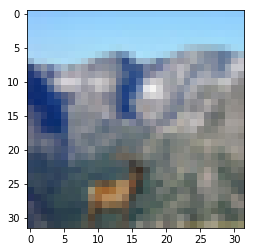

LABEL: 4 = deer


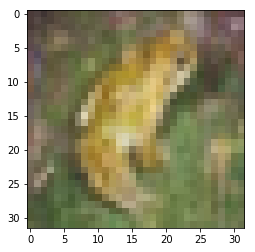

LABEL: 6 = frog


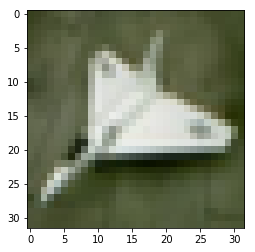

LABEL: 0 = airplane


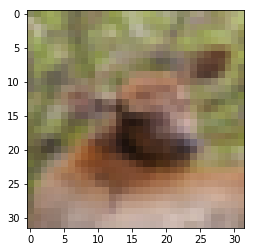

LABEL: 4 = deer


In [19]:
# Read an arbitrary image.
f = tables.open_file("data/cifar10/data.h5", mode="r")
todo_vals = [1509, 1959, 1988, 9018]
for i in range(len(todo_vals)):
    todo = todo_vals[i]
    myinput = f.root.train.inputs.read(start=todo, stop=(todo+1), step=1)
    mylabel = f.root.train.labels.read(start=todo, stop=(todo+1), step=1)
    myim = myinput.flatten().reshape((3,32,32))
    myim = np.swapaxes(myim, 0, 1) # note the axis swapping.
    myim = np.swapaxes(myim, 1, 2) # note the axis swapping.
    plt.imshow(myim)
    plt.show()
    print("LABEL:", mylabel[0][0], "=", LABEL_DICT[mylabel[0][0]])
f.close()

___